# Image Segmentation using Full Connected Neural Network

By [Akshaj Verma](https://akshajverma.com)


This notebook takes you through an implementation of paper [Fully Convolutional Network for Semantic Segmentation](https://arxiv.org/pdf/1411.4038.pdf) on the Indian Driving Dataset.

In [148]:
import pathlib
from tqdm.notebook import tqdm

import cv2
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

Let's define the path for our data.

In [4]:
ROOT_PATH = "../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite/"

train_images_path = ROOT_PATH + "leftImg8bit/train/"
train_labels_path = ROOT_PATH + "gtFine/train/"


val_images_path = ROOT_PATH + "leftImg8bit/val/"
val_labels_path = ROOT_PATH + "gtFine/val/"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


## Visualize Data

### Training image

Shape of the image is:  (227, 320, 3) 




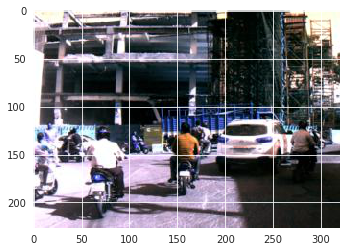

In [6]:
img = cv2.imread(train_images_path + "0/024541_image.jpg", 1)
print("Shape of the image is: ", img.shape, "\n\n")
plt.imshow(img)

### Histogram of image

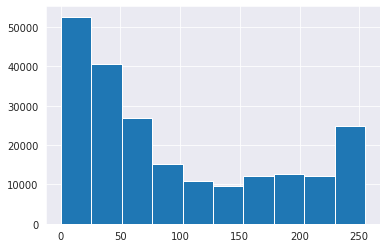

In [7]:
plt.hist(img.flatten())
plt.show()

### Training label

In [8]:
lol = Image.open(str(train_labels_path + "0/024541_label.png"))

In [9]:
np.array(lol)

array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Shape of the label is:  (227, 320, 3) 




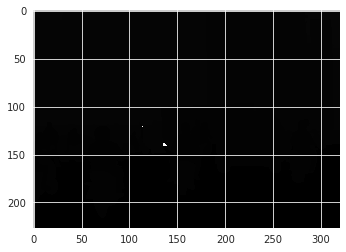

In [10]:
lbl = cv2.imread(train_labels_path + "0/024541_label.png", 1)
print("Shape of the label is: ", lbl.shape, "\n\n")
plt.imshow(lbl)

### Histogram of label

In [79]:
print("Unique lables in the image = ", np.unique(lbl))

Unique lables in the image =  [  0   2   3   4   5   6 255]


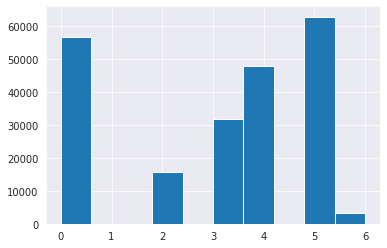

In [12]:
plt.hist(lbl.flatten(), range=[0, 6])
plt.show()

In [13]:
def enhance_seg_mask(img_path):
    img = cv2.imread(img_path, 0)
    img = img*41
    
    return img

In [14]:
enhanced_lbl = enhance_seg_mask(train_labels_path + "0/024541_label.png")
enhanced_lbl

array([[246, 246, 246, ..., 246, 246, 246],
       [246, 246, 246, ..., 246, 246, 246],
       [246, 246, 246, ..., 246, 246, 246],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

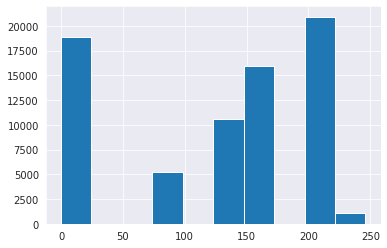

In [15]:
plt.hist(enhanced_lbl.flatten())
plt.show()

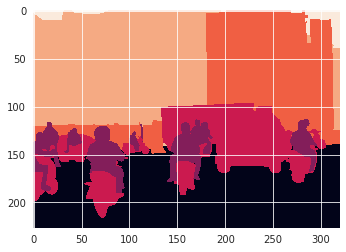

In [16]:
plt.imshow(enhanced_lbl)

## Data Preprocessing

#### Path to data

In [17]:
root_path = pathlib.Path(ROOT_PATH)

print("Root path: ", root_path)
print("")

# train paths
train_images_path = root_path.joinpath("leftImg8bit").joinpath("train")
train_labels_path = root_path.joinpath("gtFine").joinpath("train")

print("Train Images path: ", train_images_path)
print("Train Labels path: ", train_labels_path)
print("")

# test paths
test_images_path = root_path.joinpath("leftImg8bit").joinpath("val")
test_labels_path = root_path.joinpath("gtFine").joinpath("val")

print("Test Images path: ", test_images_path)
print("Test Labels path: ",test_labels_path)
print("")

Root path:  ../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite

Train Images path:  ../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite/leftImg8bit/train
Train Labels path:  ../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite/gtFine/train

Test Images path:  ../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite/leftImg8bit/val
Test Labels path:  ../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite/gtFine/val



### Create Transforms

In [18]:
IMAGE_LABEL_SIZE = 224

image_transforms = {
    "train": transforms.Compose([
#         transforms.Resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ]),
    "test": transforms.Compose([
#         transforms.Resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])
}

### Create Dataset

#### Base Dataset Class

In [19]:
class DatasetIDD(Dataset):
    def __init__(self, images_path, labels_path, image_transform, img_lbl_size):
        super(DatasetIDD, self).__init__()
        self.images_path = pathlib.Path(images_path)
        self.labels_path = pathlib.Path(labels_path)
        
        self.img_lbl_size = img_lbl_size
        self.transform = image_transform
        
        self.img_file_paths = [file for file in images_path.rglob("**/*.jpg")]
        self.lbl_file_paths = [file for file in labels_path.rglob("**/*.png") if len(file.parts[-1].split("_")) == 2 ]
        
    def __getitem__(self, idx):
        img_path = str(self.img_file_paths[idx])
        lbl_path = str(self.lbl_file_paths[idx])
        
        img = Image.open(img_path)
        img = self.transform(img)
        img = img[:, :224, :224]
        
        lbl = Image.open(lbl_path)
#         lbl = lbl.resize((self.img_lbl_size, self.img_lbl_size))
        lbl = torch.from_numpy(np.array(lbl)).long()[:224, :224]
        
        return img, lbl
    
    def __len__(self):
        return len(self.img_file_paths)

#### Train+Val Dataset

In [20]:
train_val_dataset = DatasetIDD(images_path=train_images_path, labels_path=train_labels_path, image_transform=image_transforms["train"], img_lbl_size=IMAGE_LABEL_SIZE)

#### Validation Dataset

We use `SubsetRandomSampler` to make our train and validation loaders. `SubsetRandomSampler` is used so that our each batch receives a random distribution of classes.

`SubsetRandomSampler(indices)` takes as input the indices of data.

We first create our samplers and then we'll pass it to our dataloaders.

* Create a list of indices.
* Shuffle the indices.
* Split the indices based on train-val percentage.
* Create SubsetRandomSampler.

Create a list of indices from 0 to length of dataset.

In [21]:
train_val_dataset_size = len(train_val_dataset)
train_val_dataset_indices = list(range(train_val_dataset_size))

Shuffle the list of indices using `np.shuffle`.

In [22]:
np.random.shuffle(train_val_dataset_indices)

Create the split index. We choose the split index to be 20% (0.2) of the dataset size.

In [23]:
val_split_index = int(np.floor(0.2 * train_val_dataset_size))

Slice the lists to obtain 2 lists of indices, one for train and other for test.

`0-----------val_split_index------------------------------n`

Train => val_split_index to n

Val => 0 to val_split_index

In [24]:
train_idx, val_idx = train_val_dataset_indices[val_split_index:], train_val_dataset_indices[:val_split_index]

Finally, create samplers.

In [25]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

#### Test Dataset

In [26]:
test_dataset = DatasetIDD(images_path=test_images_path, labels_path=test_labels_path, image_transform=image_transforms["test"], img_lbl_size=IMAGE_LABEL_SIZE)

### Create Dataloaders

In [27]:
train_loader = DataLoader(dataset=train_val_dataset, shuffle=False, batch_size=8, sampler = train_sampler)
val_loader = DataLoader(dataset=train_val_dataset, shuffle=False, batch_size=1, sampler = val_sampler)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

### Data Sanity Check

In [28]:
print("Shape of image from train-loader = ", next(iter(train_loader))[0].shape)
print("Shape of label from train-loader = ", next(iter(train_loader))[1].shape)

print("\nShape of image from val-loader = ", next(iter(val_loader))[0].shape)
print("Shape of label from val-loader = ", next(iter(val_loader))[1].shape)

print("\nShape of image from test-loader = ", next(iter(test_loader))[0].shape)
print("Shape of label from test-loader = ", next(iter(test_loader))[1].shape)

Shape of image from train-loader =  torch.Size([8, 3, 224, 224])
Shape of label from train-loader =  torch.Size([8, 224, 224])

Shape of image from val-loader =  torch.Size([1, 3, 224, 224])
Shape of label from val-loader =  torch.Size([1, 224, 224])

Shape of image from test-loader =  torch.Size([1, 3, 224, 224])
Shape of label from test-loader =  torch.Size([1, 224, 224])


## FCN Model

In [29]:
class ModelFCN8(nn.Module):
    def __init__(self, num_class):
        super(ModelFCN8, self).__init__()
        self.num_class = num_class
        
        
        self.block_1_1 = self.conv_block(c_in=3, c_out=64, kernel_size=3, stride=1, padding=1)
        self.block_1_2 = self.conv_block(c_in=64, c_out=64, kernel_size=3, stride=1, padding=1)
        
        self.block_2_1 = self.conv_block(c_in=64, c_out=128, kernel_size=3, stride=1, padding=1)
        self.block_2_2 = self.conv_block(c_in=128, c_out=128, kernel_size=3, stride=1, padding=1)
        self.block_2_3 = self.conv_block(c_in=128, c_out=128, kernel_size=3, stride=1, padding=1)
        
        self.block_3_1 = self.conv_block(c_in=128, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block_3_2 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block_3_3 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        
        self.block_4_1 = self.conv_block(c_in=256, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_4_2 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_4_3 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        
        self.block_5_1 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_5_2 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_5_3 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        
        
        self.block_5_fcn2 = nn.ConvTranspose2d(num_class, num_class, kernel_size=3, stride=2, padding=1)
        self.block_5_4_fcn2 = nn.ConvTranspose2d(num_class, num_class, kernel_size=3, stride=2, padding=1)
        self.block_5_4_3_fcn8 = nn.ConvTranspose2d(num_class, num_class, kernel_size=3, stride=8, padding=1)
        
        self.conv1x1_512_4096 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=1, stride=1, padding=0)
        self.conv1x1_4096_7 = nn.Conv2d(in_channels=4096, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        self.conv1x1_512_7 = nn.Conv2d(in_channels=512, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        self.conv1x1_256_7 = nn.Conv2d(in_channels=256, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        
        self.final_conv = nn.Conv2d(in_channels=num_class, out_channels=num_class, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    
    def forward(self, x):
                              # 3 x 224 x 224
        x1 = self.block_1_1(x)
        x1 = self.block_1_2(x1)
        
        x1 = self.maxpool(x1) # 64 x 112 x 112
        
        x2 = self.block_2_1(x1)
        x2 = self.block_2_2(x2)
        x2 = self.block_2_3(x2)
        
        x2 = self.maxpool(x2) # 128 x 56 x 56
        
        x3 = self.block_3_1(x2)
        x3 = self.block_3_2(x3)
        x3 = self.block_3_3(x3)
        
        x3 = self.maxpool(x3) # 256 x 28 x 28
        
        x4 = self.block_4_1(x3)
        x4 = self.block_4_2(x4)
        x4 = self.block_4_3(x4)
        
        x4 = self.maxpool(x4) # 512 x 14 x 14
        
        x5 = self.block_5_1(x4)
        x5 = self.block_5_2(x5)
        x5 = self.block_5_3(x5) 
        
        x5 = self.maxpool(x5) # 512 x 8 x 8
        
        o = self.conv1x1_512_4096(x5) # 4096 x 8 x 8
        o = self.conv1x1_4096_7(o) # 8 x 8 x 8
        
        
        # Transpose Convs
        o1 = self.block_5_fcn2(o, output_size=x4.shape) # 8, 14, 14
        o1 = o1 + self.conv1x1_512_7(x4)
        o2 = self.block_5_4_fcn2(o1, output_size=x3.shape) # 8, 28, 28
        o2 = o2 + self.conv1x1_256_7(x3)
        o3 = self.block_5_4_3_fcn8(o2, output_size=x.shape) # 8, 224, 224
        
        
        output = self.final_conv(o3)


        return output

        
    def conv_block(self, c_in, c_out, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU()
        )
        
        return seq_block

In [30]:
model = ModelFCN8(num_class=8)
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.001)

ModelFCN8(
  (block_1_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2_3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, 

In [31]:
loss_stats = {
    'train': [],
    "val": []
}

In [32]:
print("Begin training.")

for e in tqdm(range(1, 21)):
    
    # TRAINING
    train_epoch_loss = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
                              
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


Epoch 01: | Train Loss: 1.61532 | Val Loss: 1.42683
Epoch 02: | Train Loss: 1.38656 | Val Loss: 1.34214
Epoch 03: | Train Loss: 1.35905 | Val Loss: 1.41667
Epoch 04: | Train Loss: 1.35039 | Val Loss: 1.54037
Epoch 05: | Train Loss: 1.34521 | Val Loss: 1.52013
Epoch 06: | Train Loss: 1.34110 | Val Loss: 1.37710
Epoch 07: | Train Loss: 1.33911 | Val Loss: 1.40256
Epoch 08: | Train Loss: 1.33609 | Val Loss: 1.42579
Epoch 09: | Train Loss: 1.33351 | Val Loss: 1.47771
Epoch 10: | Train Loss: 1.33011 | Val Loss: 1.55375
Epoch 11: | Train Loss: 1.33201 | Val Loss: 1.27178
Epoch 12: | Train Loss: 1.32740 | Val Loss: 1.30607
Epoch 13: | Train Loss: 1.32602 | Val Loss: 1.32668
Epoch 14: | Train Loss: 1.32329 | Val Loss: 1.34246
Epoch 15: | Train Loss: 1.32343 | Val Loss: 1.31190
Epoch 16: | Train Loss: 1.32295 | Val Loss: 1.42426
Epoch 17: | Train Loss: 1.32289 | Val Loss: 1.59056
Epoch 18: | Train Loss: 1.31984 | Val Loss: 1.41307
Epoch 19: | Train Loss: 1.31719 | Val Loss: 1.39936
Epoch 20: | 

## Visualize Loss

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

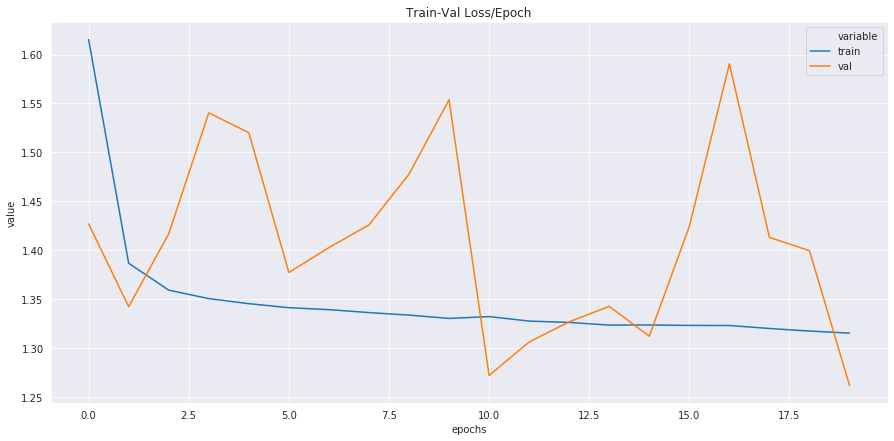

In [121]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

plt.figure(figsize=(15, 7))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

## Test Model

In [54]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_tag = y_pred_tag
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [161]:
mean_iou = jaccard_score(y_true_list[0].squeeze().flatten(), y_pred_list[0].squeeze().flatten(), average="macro")

In [162]:
mean_iou

0.11918765228960387

## Visualize Results

In [139]:
def array_to_img_for_viz(arr):
    arr = arr * 41
    arr = arr.squeeze()
    arr = np.uint8(arr)
    arr_img = Image.fromarray(arr)
    
    return arr_img  

Text(0.5, 1.0, 'Predicted Mask')

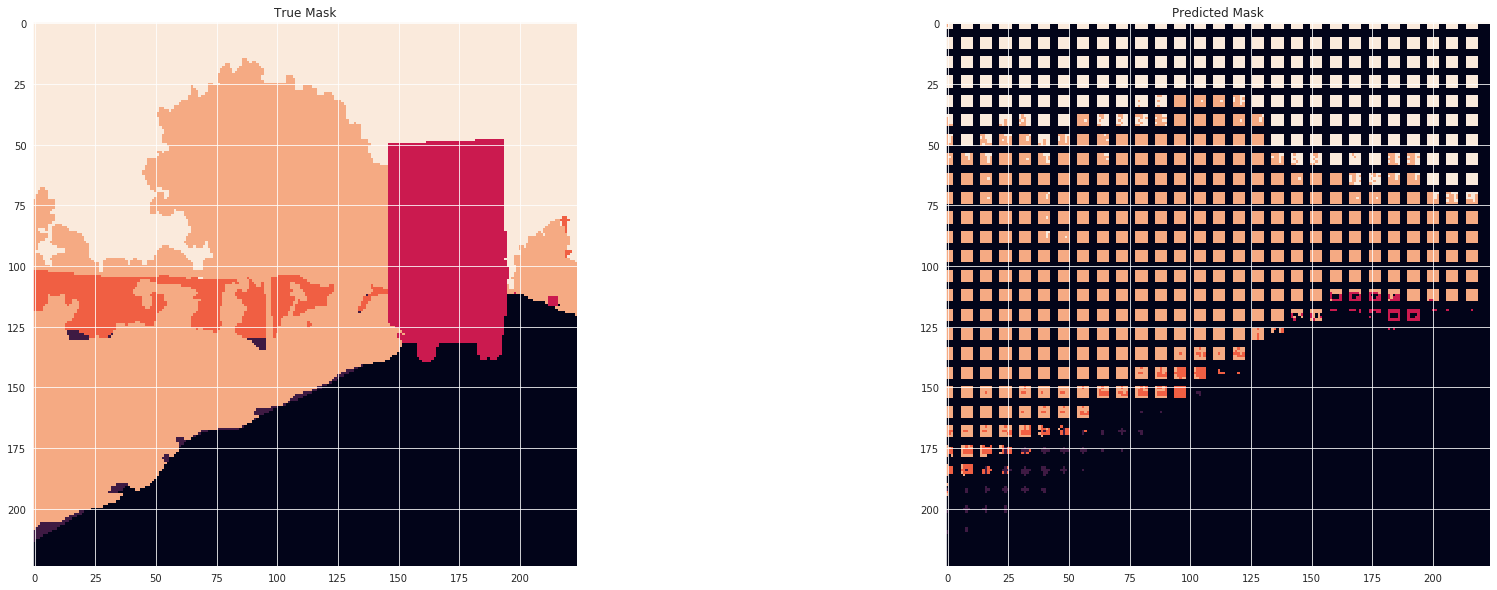

In [160]:
image_index_to_view = 10


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].imshow(array_to_img_for_viz(y_true_list[image_index_to_view]))
axes[0].set_title("True Mask")
axes[1].imshow(array_to_img_for_viz(y_pred_list[image_index_to_view]))
axes[1].set_title("Predicted Mask")